In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time


# We will compute against spectral measurements by a trapezoidal rule

# Elliptic equation in 1D
We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

Iou casem we will have the domain be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_i \sin\Big(n\pi x\Big) \\
u &=  \sqrt{2}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)}\sin\Big(n\pi x\Big)
\end{aligned}


In [36]:
key = random.PRNGKey(0)
nu = 1e-2

n_coef = 5000
coef_f = random.normal(key, shape= (n_coef,))

frequencies = jnp.arange(1, n_coef+1)

coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 +1)

In [41]:
lower = 0.0
upper = 1.0
x = jnp.linspace(lower, upper, 1000)

def evaluate_sine(x, c, n):
    return c*jnp.sin(n*jnp.pi*x)*jnp.sqrt(2)

def evaluate_sine_basis(x,c):
    n = jnp.arange(1, c.shape[0]+1)
    return jnp.sum(vmap(evaluate_sine, in_axes =(None,0, 0))(x,c, n), axis = 0)

In [42]:
f_eval = evaluate_sine_basis(x, coef_f)
u_eval = evaluate_sine_basis(x, coef_u)

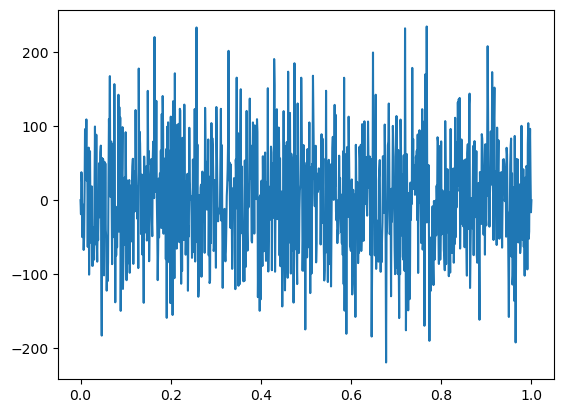

In [43]:
plt.plot(x, f_eval)

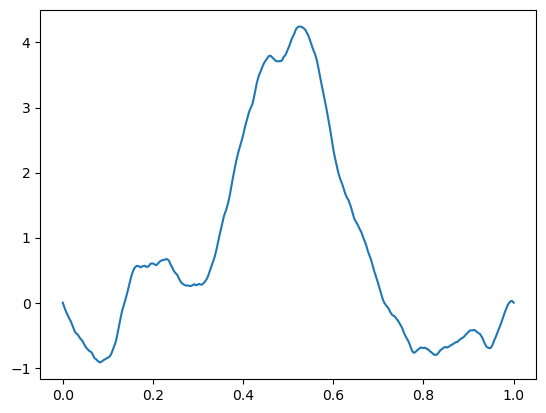

In [44]:
plt.plot(x, u_eval)

In [45]:
from utils_elliptic_coef import L_b_xy, vmap_L_b_xy, vmap_L_b_y

In [46]:
b =lambda x : jnp.ones_like(x)*1.0
length_scale = 1.0
boundary = jnp.hstack([lower, upper])

In [61]:
def integrate_sine(points, k, l, K):
     G = K*jnp.outer(jnp.sqrt(2)*jnp.sin(2*jnp.pi*k*points), jnp.sqrt(2)*jnp.sin(2*jnp.pi*l*points))
     return integrate.trapezoid(integrate.trapezoid(G, points), points)

vmap_integrate_sine = vmap(vmap(integrate_sine, in_axes = (None, 0, None, None)), in_axes = (None, None, 0, None))

In [62]:
domain_integrate = jnp.linspace(lower, upper, 500)
theta_22 = vmap_L_b_xy(domain_integrate, domain_integrate, length_scale,nu, b(domain_integrate), b(domain_integrate))

In [63]:
k,l = 3,5
integrate_sine(domain_integrate, k, l, theta_22)

0.003565272396069347

In [64]:
theta_22 = vmap_integrate_sine(domain_integrate, frequencies, frequencies, theta_22)

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory allocating 50000000000000 bytes.